In [1]:
from src.io.datasets import CSVReader
from src.config.settings import get_settings
from src.config.training_settings import get_training_settings

In [2]:
settings = get_settings()
training_settings = get_training_settings()

reader = CSVReader()

In [3]:
train_file = training_settings.TRAIN_FILE
test_file = training_settings.TEST_FILE

train_data = reader.read(train_file)
test_data = reader.read(test_file)

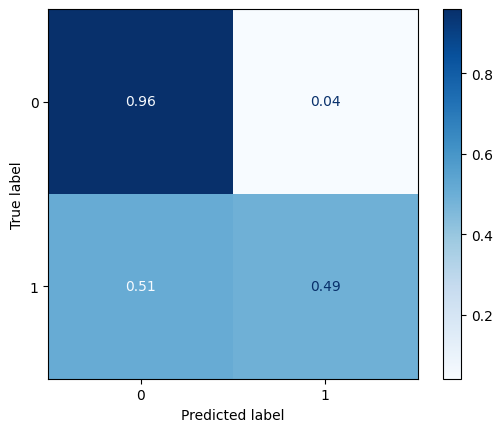

In [4]:
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

features = training_settings.ALL_FEATURES
target = training_settings.TARGET

X_train, y_train = train_data[features], train_data[target]
y_train = y_train.fillna(0)
X_test, y_test = test_data[features], test_data[target]
y_test = y_test.fillna(0)

negative_class_count = np.bincount(y_train.astype(int))[0]
positive_class_count = np.bincount(y_train.astype(int))[1]
scale_pos_weight = (negative_class_count / positive_class_count)

# Train the XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=model.classes_)
cm_display.plot(cmap="Blues", values_format=".2f")

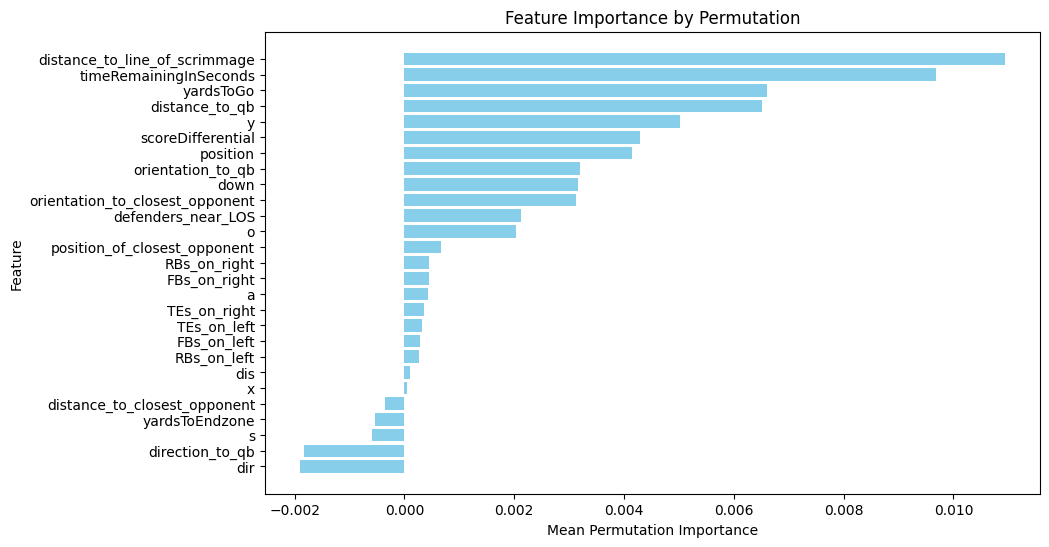

In [5]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

result = permutation_importance(
    model, X_train, y_train, scoring="accuracy", n_repeats=10, random_state=42
)

sorted_idx = result.importances_mean.argsort()[::-1]
sorted_features = [features[i] for i in sorted_idx]
importances = result.importances_mean[sorted_idx]

# Display feature importance
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, importances, color="skyblue")
plt.xlabel("Mean Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importance by Permutation")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

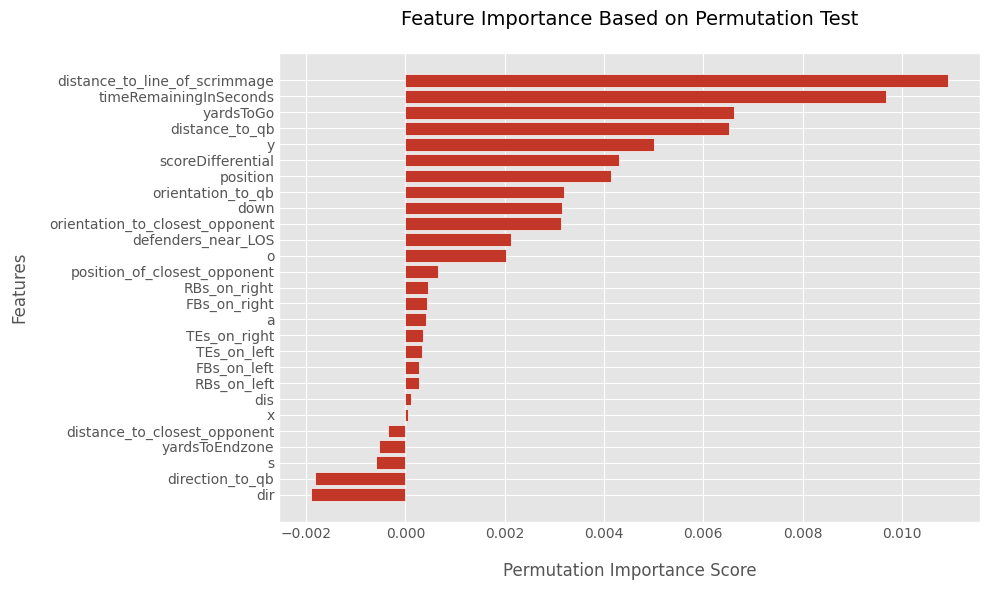

In [10]:
plt.style.use('ggplot')  # ggplot style for a clean look
plt.figure(figsize=(10, 6))

# Create the bar plot with the new color
plt.barh(sorted_features, importances, color="#c23728", edgecolor="white")

# Improve the title and labels with clearer descriptions
plt.xlabel("Permutation Importance Score", fontsize=12, labelpad=15)
plt.ylabel("Features", fontsize=12, labelpad=15)
plt.title("Feature Importance Based on Permutation Test", fontsize=14, pad=20)

# Invert the y-axis for better readability
plt.gca().invert_yaxis()

# Refine the layout with no ticks on top/bottom
plt.tick_params(axis='both', which='both', length=0)
plt.tight_layout()
plt.savefig("../reports/figures/feature_importance_permutation.png", dpi=300)
# Display the plot
plt.show()